In [1]:
import tensorflow as tf
from IPython.display import Image, display

import matplotlib.pyplot as plt
import tensorflow_hub as hub

import numpy as np

import warnings
import zipfile
warnings.filterwarnings('ignore')

In [2]:
tf.keras.backend.clear_session()

In [3]:
!nvidia-smi

Sun Jun  6 09:11:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
main_path = "/content/drive/MyDrive/Dataset/Jaguar_Cheetha_Tiger.zip"

In [5]:
# Unzipping the data file
zip_ref = zipfile.ZipFile(main_path, 'r')
zip_ref.extractall("/content/")
zip_ref.close()

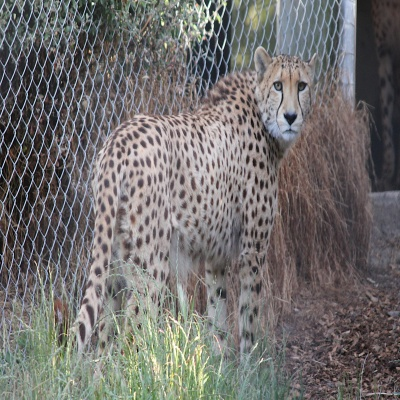

In [6]:
display(Image('/content/Jaguar_Cheetha_Tiger/Train/cheetah_train_resized/cheetah_000_resized.jpg'))

In [7]:
batch_size = 128
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/Jaguar_Cheetha_Tiger/Train',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 3 classes.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory('/content/Jaguar_Cheetha_Tiger/Test',
  seed=111,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 300 files belonging to 3 classes.


In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [12]:
classes=train_ds.class_names
print(classes)

['cheetah_train_resized', 'jaguar_train_resized', 'tiger_train_resized']


In [13]:
classes = ['cheetah', 'jaguar', 'tiger']
print(classes)

['cheetah', 'jaguar', 'tiger']


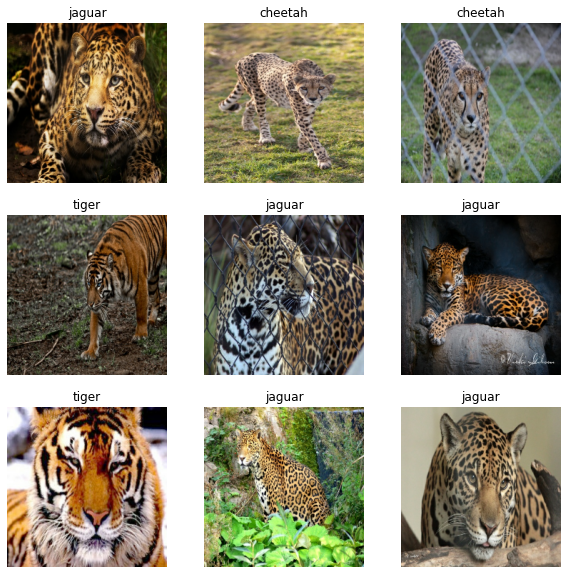

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
feature_extractor = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [18]:
feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height,img_width,3))

In [19]:
feature_extractor_layer.trainable = False

In [20]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [21]:
tf.random.set_seed(111)

In [22]:
model = tf.keras.Sequential([
  normalization_layer,
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(3,activation='softmax')
])

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [25]:
# Callbacks:
# Exponential decay
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [26]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
22/22 [==============================] - 41s 270ms/step - loss: 0.4881 - accuracy: 0.8278 - val_loss: 0.0921 - val_accuracy: 0.9933
Epoch 2/20
22/22 [==============================] - 3s 152ms/step - loss: 0.0693 - accuracy: 0.9915 - val_loss: 0.0472 - val_accuracy: 0.9933
Epoch 3/20
22/22 [==============================] - 3s 153ms/step - loss: 0.0426 - accuracy: 0.9941 - val_loss: 0.0401 - val_accuracy: 0.9933
Epoch 4/20
22/22 [==============================] - 3s 153ms/step - loss: 0.0371 - accuracy: 0.9933 - val_loss: 0.0372 - val_accuracy: 0.9933
Epoch 5/20
22/22 [==============================] - 3s 154ms/step - loss: 0.0363 - accuracy: 0.9926 - val_loss: 0.0347 - val_accuracy: 0.9933
Epoch 6/20
22/22 [==============================] - 3s 153ms/step - loss: 0.0322 - accuracy: 0.9944 - val_loss: 0.0334 - val_accuracy: 0.9933
Epoch 7/20
22/22 [==============================] - 3s 154ms/step - loss: 0.0304 - accuracy: 0.9937 - val_loss: 0.0326 - val_accuracy: 0.9933
Epoch

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


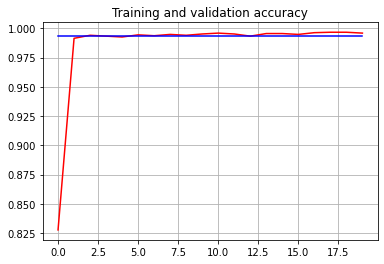

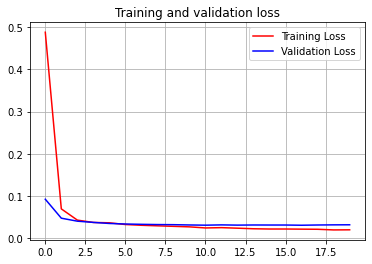

In [30]:
# Graph between Training Accuracy and Validation Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()

# Graph between Training Loss and Validation Loss

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()

# # Graph for Learning rate ~ Exponential Decay
# plt.plot(history.epoch, history.history["lr"], "o-")
# plt.xlabel("Epoch")
# plt.ylabel("Learning Rate")
# plt.title(" exponential_decay", fontsize=14)
# plt.grid(True)
# plt.show()

In [31]:
model.save('./models', save_format='tf')

INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


In [32]:
!ls -alrt models

total 2052
drwxr-xr-x 1 root root    4096 Jun  6 09:21 ..
drwxr-xr-x 2 root root    4096 Jun  6 09:21 variables
drwxr-xr-x 2 root root    4096 Jun  6 09:21 assets
-rw-r--r-- 1 root root 2074332 Jun  6 09:21 saved_model.pb
-rw-r--r-- 1 root root    6617 Jun  6 09:21 keras_metadata.pb
drwxr-xr-x 4 root root    4096 Jun  6 09:21 .


In [33]:
model_loaded = tf.keras.models.load_model('./models/')

In [34]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [36]:
pred_label=model_loaded.predict(process('/content/Jaguar_Cheetha_Tiger/Test/cheetah_validation_resized/cheetah_001_val_resized.jpg'))
print(classes[np.argmax(pred_label)])

cheetah


In [37]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/assets/ (stored 0%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/saved_model.pb (deflated 92%)
  adding: models/keras_metadata.pb (deflated 81%)
